# Billboard Chart -- Data Analysis

In [192]:
import numpy as np
import pandas as pd
from pandas import Categorical as cat
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from pandas import DataFrame, Series
import statsmodels.formula.api as sm
from sklearn.linear_model import LinearRegression
import scipy, scipy.stats

plotly.offline.init_notebook_mode()

%matplotlib inline

In [193]:
df = pd.read_csv('assets/billboard.csv')

In [194]:
df.head(2)

,year,artist.inverted,track,time,genre,date.entered,date.peaked,x1st.week,x2nd.week,x3rd.week,...,x67th.week,x68th.week,x69th.week,x70th.week,x71st.week,x72nd.week,x73rd.week,x74th.week,x75th.week,x76th.week
0,2000,Destiny's Child,Independent Women Part I,"3,38,00 AM",Rock,"September 23, 2000","November 18, 2000",78,63,49,...,*,*,*,*,*,*,*,*,*,*
1,2000,Santana,"Maria, Maria","4,18,00 AM",Rock,"February 12, 2000","April 8, 2000",15,8,6,...,*,*,*,*,*,*,*,*,*,*


In [195]:
len(df.columns)

83

In [196]:
df.dtypes[0:8]

year                int64
artist.inverted    object
track              object
time               object
genre              object
date.entered       object
date.peaked        object
x1st.week           int64
dtype: object

In [197]:
df['year'].value_counts()

2000    317
Name: year, dtype: int64

In [198]:
del df['year']

In [200]:
print "Number of unique artist names: %s" %len(df['artist.inverted'].unique())
print "Number of unique song titles: %s" %len(df['track'].unique())
print "Length of dataframe: %s" %len(df)

Number of unique artist names: 228
Number of unique song titles: 316
Length of dataframe: 317


In [201]:
## Make sure songs with same title are actually different tracks
def same_track(df):
    for i in range(len(df)):
        for j in range(len(df)):
            if i == j:
                continue
            elif df['track'][i] == df['track'][j]:
                if i > j:
                    df['track'][j] = '%s2' %df['track'][j]
                    print "The song, \"%s,\"" %df['track'][i] + " is sung by %s" \
                        %df['artist.inverted'][i] + " and %s" %df['artist.inverted'][j]
                    print "New title of second song of same name: %s" %df['track'][j]
                else:
                    continue
    return

In [202]:
same_track(df)

The song, "Where I Wanna Be," is sung by Sheist, Shade and Jones, Donell
New title of second song of same name: Where I Wanna Be2


/Users/Rebecca/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [203]:
print "Number of distinct genres: %s" %len(df['genre'].unique()), '\n'
print "List of genre names: %s" %df['genre'].unique()

Number of distinct genres: 12 

List of genre names: ['Rock' "Rock'n'roll" 'Latin' 'Country' 'Rap' 'Pop' 'Electronica' 'Jazz'
 'R&B' 'Reggae' 'Gospel' 'R & B']


Looks like we'll have to disambiguate "R&B" and "R & B," and perhaps combine "Rock" and "Rock'n'roll":

In [205]:
df['genre'].value_counts()

Rock           103
Country         74
Rap             58
Rock'n'roll     34
R&B             13
R & B           10
Pop              9
Latin            9
Electronica      4
Gospel           1
Jazz             1
Reggae           1
Name: genre, dtype: int64

Check out singletons:

In [207]:
print df[(df['genre'] == 'Gospel') | (df['genre'] == 'Jazz') | (df['genre'] == 'Reggae')]\
[['artist.inverted', 'track', 'genre']]

    artist.inverted                               track   genre
49          Kenny G  Auld Lang Syne (The Millenium Mix)    Jazz
189      Beenie Man                     Girls Dem Sugar  Reggae
200  Adams, Yolanda                       Open My Heart  Gospel


In [208]:
df['time'].max() 

'7,50,00 AM'

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;This data frame contains information regarding songs hitting the Billboard chart in the year 2000.  It has 317 rows and 83 columns.  Artist names are in "Last/First" form (where applicable).  Two songs of the same title are performed by different artists.  Track time is listed in an unwieldy combination of minutes and seconds.  Genre names require disambiguation, as we see both, "R&B," and, "R & B," as well as, "Rock," and, "Rock'n'roll."  The "date.entered" and "date.peaked" columns will have to be converted to datetime format if we want to use them to calculate time lapsed.  Likewise, with the week columns we will have to figure what information we want to extract from them and combine with datetime information if needed.

## Clean data

In [209]:
def get_name(artist):
    '''This function changes last name, first name format to first name, last name'''
    name = artist.split(', ')
    return "%s" %name[1] + " %s" %name[0]

In [210]:
new_names = []
for i in range(len(df['artist.inverted'])):
    if ',' in df['artist.inverted'][i]:
        name = get_name(df['artist.inverted'][i])
        new_names.append(name)
    else:
        new_names.append(df['artist.inverted'][i])
        continue

In [211]:
new_names[0:10]

["Destiny's Child",
 'Santana',
 'Savage Garden',
 'Madonna',
 'Christina Aguilera',
 'Janet',
 "Destiny's Child",
 'Enrique Iglesias',
 'Sisqo',
 'Lonestar']

In [212]:
df['artist.inverted'] = new_names
df.rename(columns={'artist.inverted':'artist'}, inplace=True)

Clean up repeat genre names:

In [218]:
df['genre'] = df['genre'].apply(lambda x: x.replace('Rock\'n\'roll', 'Rock'))
df['genre'] = df['genre'].apply(lambda x: x.replace('R & B', 'R&B'))
df['genre'] = df['genre'].apply(lambda x: x.replace('R&B', 'RnB'))
df['genre'] = df['genre'].astype('category')
print df['genre'].unique()

[Rock, Latin, Country, Rap, Pop, Electronica, Jazz, RnB, Reggae, Gospel]
Categories (10, object): [Rock, Latin, Country, Rap, ..., Jazz, RnB, Reggae, Gospel]


In [219]:
df['genre'].value_counts()

Rock           137
Country         74
Rap             58
RnB             23
Pop              9
Latin            9
Electronica      4
Reggae           1
Jazz             1
Gospel           1
Name: genre, dtype: int64

In [220]:
## Let's only analyze top four genres 

df = df[(df['genre'] == 'Rock') | (df['genre'] == 'Country') | (df['genre'] == 'Rap') | \
       (df['genre'] == 'RnB')]

print "New number of songs:  %s" %len(df)
print "New number of genres: %s" %len(df['genre'].unique())

New number of songs:  292
New number of genres: 4


In [221]:
df['entering_position'] = df['x1st.week'].apply(lambda x: float(x))

In [222]:
## Change name and type of 'time' column
df['time'] = df['time'].apply(lambda x: x.replace(',00 AM', ''))
df.rename(columns={'time':'length'}, inplace=True)

In [223]:
def get_sec(s):
    '''This function converts a comma-separated string of minutes and seconds into a value \
    of seconds only'''
    time = s.split(',')
    return float(int(time[0]) * 60 + int(time[1]))

In [224]:
df['length'] = df['length'].apply(lambda x: get_sec(x))
df['length'].head()

0    218.0
1    258.0
2    247.0
3    225.0
4    218.0
Name: length, dtype: float64

In [225]:
## Change chart dates to pandas datetime objects and replace dots with underscores to match \
## rest of column names
df['date.entered'] = pd.to_datetime(df['date.entered'])
df.rename(columns={'date.entered':'date_entered'}, inplace=True)
df['date.peaked'] = pd.to_datetime(df['date.peaked'])
df.rename(columns={'date.peaked':'date_peaked'}, inplace=True)

In [226]:
## Calculate number of days between a song entering the chart and its obtaining peak position
df['weeks_to_peak'] = ((df['date_peaked']-df['date_entered'])/7).apply(lambda x: float(x.days))
df['weeks_to_peak'].head()

0     8.0
1     8.0
2    14.0
3     5.0
4    10.0
Name: weeks_to_peak, dtype: float64

In [227]:
df = df.reset_index(drop=True)

In [228]:
df.head(1)

,artist,track,length,genre,date_entered,date_peaked,x1st.week,x2nd.week,x3rd.week,x4th.week,...,x69th.week,x70th.week,x71st.week,x72nd.week,x73rd.week,x74th.week,x75th.week,x76th.week,entering_position,weeks_to_peak
0,Destiny's Child,Independent Women Part I,218.0,Rock,2000-09-23,2000-11-18,78,63,49,33,...,*,*,*,*,*,*,*,*,78.0,8.0


In [229]:
new_df = pd.melt(df, col_level=0, id_vars=['artist', 'track', 'length', 'date_entered', \
                    'date_peaked', 'weeks_to_peak'], value_vars= list(df.columns.values[6:82]))

In [230]:
new_df.head(1)

,artist,track,length,date_entered,date_peaked,weeks_to_peak,variable,value
0,Destiny's Child,Independent Women Part I,218.0,2000-09-23,2000-11-18,8.0,x1st.week,78


## Visualize Data

In [231]:
## Find highest chart position attained by each song (lowest position number)
df_weeks = df.drop(['artist', 'track', 'genre', 'length', 'entering_position', \
                    'weeks_to_peak', 'date_entered', 'date_peaked'], axis=1, inplace=False)
df_weeks = df_weeks.replace('*', 'NaN')    
df_weeks = df_weeks.applymap(lambda x: float(x))

In [232]:
peak_pos = []
for i in range(len(df_weeks)):
    pos = df_weeks.iloc[i, :].min()
    peak_pos.append(pos)

In [233]:
df['peak_position'] = peak_pos
df = df[['artist', 'track', 'genre', 'length', \
         'entering_position', 'peak_position', 'weeks_to_peak']]

In [234]:
df.head(1)

,artist,track,genre,length,entering_position,peak_position,weeks_to_peak
0,Destiny's Child,Independent Women Part I,Rock,218.0,78.0,1.0,8.0


In [235]:
df.tail(1)

,artist,track,genre,length,entering_position,peak_position,weeks_to_peak
291,Fragma,Toca's Miracle,RnB,202.0,99.0,99.0,0.0


In [236]:
df.sort_values('peak_position', axis=0, ascending=True, inplace=False, kind='quicksort', \
               na_position='last').head()

,artist,track,genre,length,entering_position,peak_position,weeks_to_peak
0,Destiny's Child,Independent Women Part I,Rock,218.0,78.0,1.0,8.0
15,Mariah Carey,Thank God I Found You,Rock,254.0,82.0,1.0,10.0
14,matchbox twenty,Bent,Rock,252.0,60.0,1.0,12.0
13,Aaliyah,Try Again,Rock,243.0,59.0,1.0,13.0
12,Creed,With Arms Wide Open,Rock,232.0,84.0,1.0,26.0


In [237]:
def round_this(float_list):
    '''A function to round a list of float objects.'''
    rounded_list = []
    for i in float_list:
        x = round(i)
        rounded_list.append(x)
    return rounded_list

def some_stats(col_name, col_data):
    '''A function to print out info on a column argument.'''
    print "Column Summary"
    print "Name: %s" %col_name
    print "Mean: %s" %np.mean(col_data)
    print "Median: %s" %np.median(col_data)
    rounded_contents = round_this(col_data)
    print "Rounded mode: %s" %str(stats.mode(rounded_contents)[0][0])
    print "Variance: %s" %np.var(col_data)
    print "Standard deviation: %s" %np.std(col_data)
    
    return

In [238]:
some_stats('length', df['length'])

Column Summary
Name: length
Mean: 241.075342466
Median: 236.5
Rounded mode: 230.0
Variance: 1448.8984331
Standard deviation: 38.0643984991


In [239]:
some_stats('entering_position', df['entering_position'])

Column Summary
Name: entering_position
Mean: 80.1369863014
Median: 81.0
Rounded mode: 77.0
Variance: 218.631919685
Standard deviation: 14.7862070757


In [240]:
some_stats('peak_position', df['peak_position'])

Column Summary
Name: peak_position
Mean: 44.5547945205
Median: 43.0
Rounded mode: 1.0
Variance: 849.2196003
Standard deviation: 29.1413726564


In [241]:
some_stats('weeks_to_peak', df['weeks_to_peak'])

Column Summary
Name: weeks_to_peak
Mean: 7.43493150685
Median: 7.0
Rounded mode: 7.0
Variance: 35.3896017076
Standard deviation: 5.94891601114


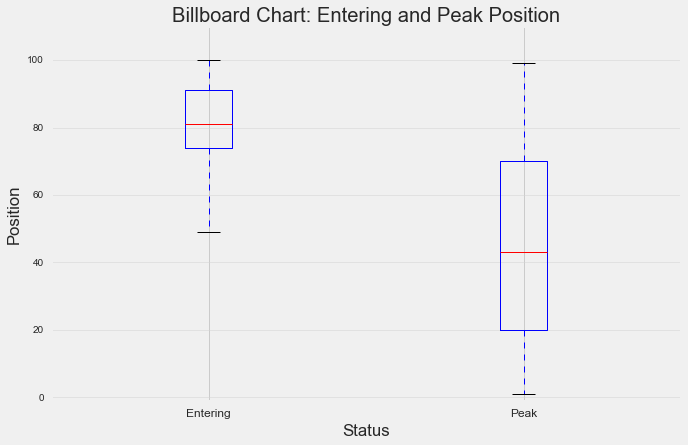

In [246]:
data = [df['entering_position'], df['peak_position']]
plt.style.use('fivethirtyeight')
fig, ax1 = plt.subplots(figsize=(10, 8))
fig.canvas.set_window_title('A Boxplot Example')
plt.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)

bp = plt.boxplot(data, notch=0, sym='+', vert=1, whis=1.5)

ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)

ax1.set_axisbelow(True)
ax1.set_title('Billboard Chart: Entering and Peak Position')
ax1.set_xlabel('Status')
ax1.set_ylabel('Position')

# Set the axes ranges and axes labels
numBoxes = 2
ax1.set_xlim(0.5, numBoxes + 0.5)
ax1.set_ylim(-1, 110)
xtickNames = plt.setp(ax1, xticklabels=['Entering', 'Peak'])
plt.setp(xtickNames, fontsize=12)

plt.show()

## http://matplotlib.org/examples/pylab_examples/boxplot_demo2.html

From these boxplots we can see that songs tend to enter lower and then peak.  This occurs, on average, after about seven weeks according to the figures above using the some_stats function.

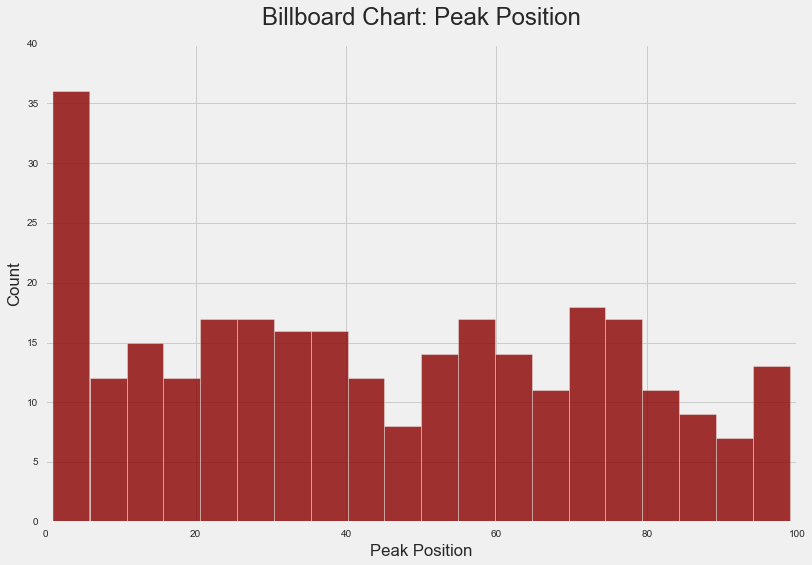

In [247]:
## Plot a histogram of peak chart position 
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

df_hist = plt.hist(df['peak_position'], color = 'darkred', bins = 20, alpha = 0.8)

plt.title('Billboard Chart: Peak Position', fontsize = 24, y = 1.03)

# y label
plt.ylabel('Count')

# x label
plt.xlabel('Peak Position')

plt.show()

This histogram is all over the place!  It appears fairly uniformly distributed except for a spike near the very top chart positions, which probably has to do with marketing and advance hype of certain albums/songs.

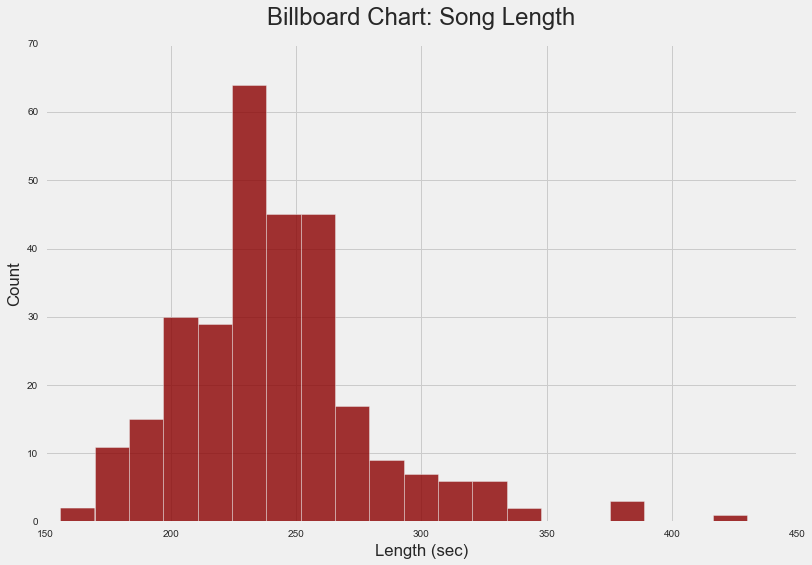

In [248]:
## Plot a histogram of Song Length 
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

df_hist = plt.hist(df['length'], color = 'darkred', bins = 20, alpha = 0.8)

plt.title('Billboard Chart: Song Length', fontsize = 24, y = 1.03)

# y label
plt.ylabel('Count')

# x label
plt.xlabel('Length (sec)')

plt.show()

Distribution for this bar chart looks pretty normal with a right skew for some longer songs.

In [249]:
## These are all songs longer than 350 seconds
df[df['length'] > 350]

,artist,track,genre,length,entering_position,peak_position,weeks_to_peak
90,D'Angelo,Untitled (How Does It Feel),RnB,430.0,77.0,25.0,4.0
105,Donell Jones,Where I Wanna Be2,Rock,382.0,81.0,29.0,11.0
210,Kelly Price,As We Lay,Rock,380.0,82.0,64.0,3.0
260,Dave Hollister,Can't Stay,Rock,377.0,84.0,84.0,0.0


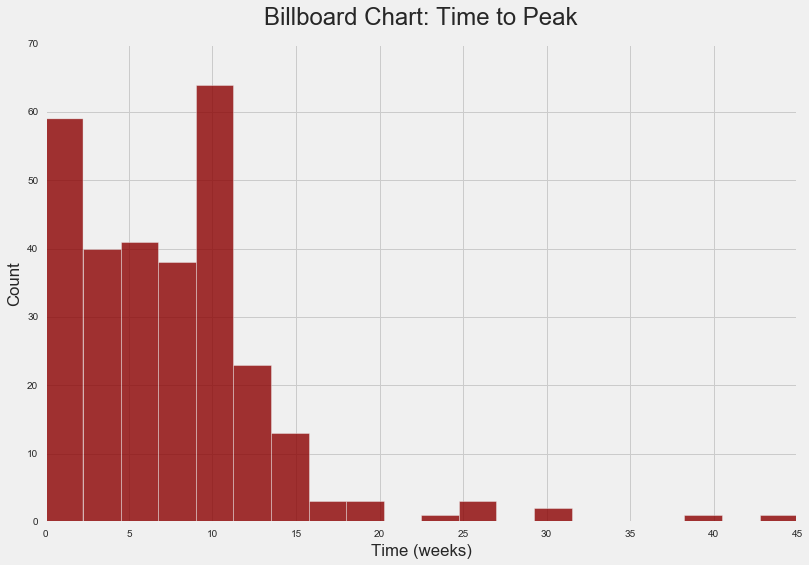

In [250]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

df_hist = plt.hist(df['weeks_to_peak'], color = 'darkred', bins = 20, alpha = 0.8)

plt.title('Billboard Chart: Time to Peak', fontsize = 24, y = 1.03)

# y label
plt.ylabel('Count')

# x label
plt.xlabel('Time (weeks)')

plt.show()

This histogram of time to reach peak chart status appears to suggest that most songs peak within 15 weeks of their release.  Many songs peak right when they come out and never make it higher on the chart (but they could be at the top or the bottom, we don't know here).

In [251]:
## These are all songs taking longer than 150 days to reach peak chart position
df[df['weeks_to_peak'] > 20]

,artist,track,genre,length,entering_position,peak_position,weeks_to_peak
8,Lonestar,Amazed,Country,265.0,81.0,1.0,39.0
11,Vertical Horizon,Everything You Want,Rock,241.0,70.0,1.0,25.0
12,Creed,With Arms Wide Open,Rock,232.0,84.0,1.0,26.0
16,Faith Hill,Breathe,Rap,244.0,81.0,2.0,24.0
22,3 Doors Down,Kryptonite,Rock,233.0,81.0,3.0,31.0
26,Joe,I Wanna Know,Rock,297.0,94.0,4.0,26.0
42,Creed,Higher,Rock,316.0,81.0,7.0,45.0
142,Amber,Sexual (Li Da Di),Rock,278.0,99.0,42.0,30.0


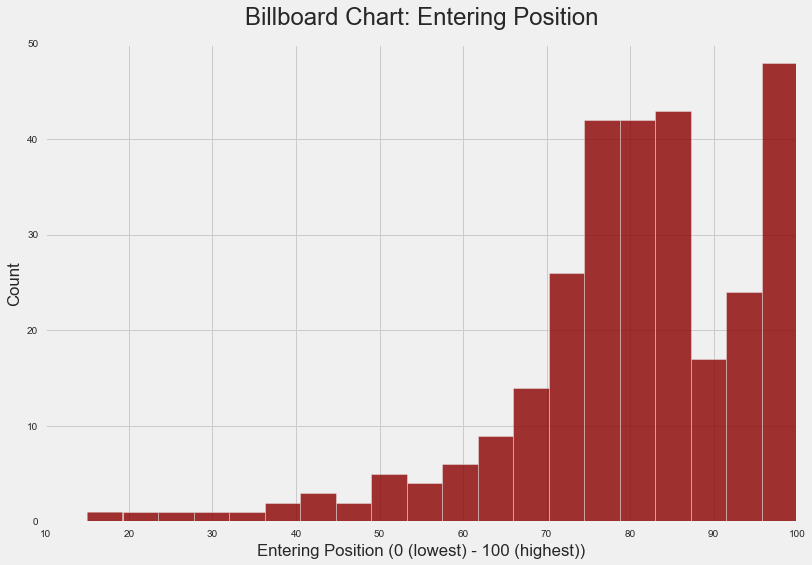

In [252]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

df_hist = plt.hist(df['entering_position'], color = 'darkred', bins = 20, alpha = 0.8)

plt.title('Billboard Chart: Entering Position', fontsize = 24, y = 1.03)

# y label
plt.ylabel('Count')

# x label
plt.xlabel('Entering Position (0 (lowest) - 100 (highest))')

plt.show()

As we see from this histogram, it appears far more likely that a song will enter from the bottom of the chart than from the top.  Possible left-skewed normal distribution with a cutoff at position 100, so hard to tell for sure.

In [253]:
## These are all songs entering the chart at position 30 or higher (lower numerical value \
## being a higher ranking) 
df[df['entering_position'] < 30]

,artist,track,genre,length,entering_position,peak_position,weeks_to_peak
1,Santana,"Maria, Maria",Rock,258.0,15.0,1.0,8.0
41,Pink,There U Go,Rock,203.0,25.0,7.0,5.0
74,Hanson,This Time Around,Country,254.0,22.0,20.0,2.0
101,Mariah Carey,Crybaby,Rock,319.0,28.0,28.0,0.0


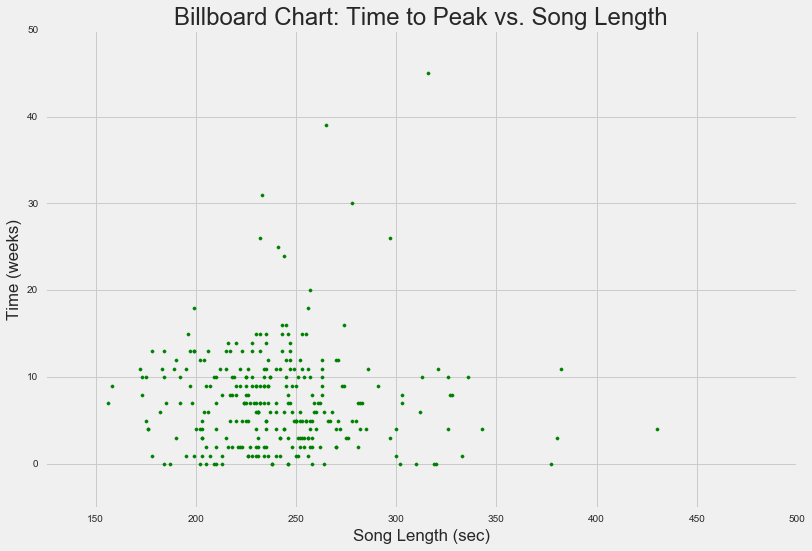

In [254]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

df_scatter = plt.scatter(df['length'], df['weeks_to_peak'], color = "green", s = 10)

plt.title('Billboard Chart: Time to Peak vs. Song Length', fontsize = 24)

# y label
plt.ylabel('Time (weeks)')

# x label
plt.xlabel('Song Length (sec)')

# set the figure boundaries
plt.xlim([125, 500])
plt.ylim([-5, 50])

plt.show()

There are some clear outliers in this plot; longer songs taking shorter time to peak, and some pretty average-length songs taking a long time to peak.  Hard to tell much from this plot besides that most songs are around 240 seconds long and peak at about 7.5 weeks, as calculated above with some_stats function.  Will make use of jittering function in a bit.

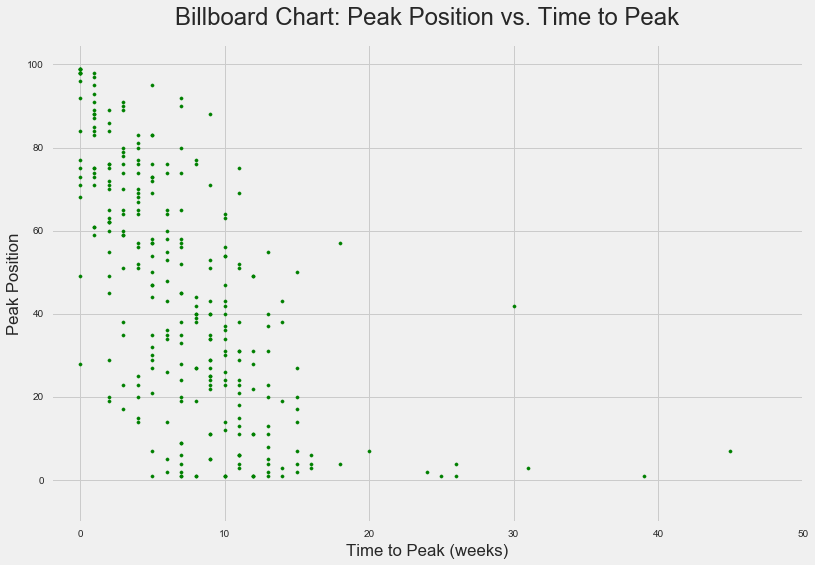

In [255]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

plt.scatter(df['weeks_to_peak'], df['peak_position'], color = "green", s = 10)

plt.title('Billboard Chart: Peak Position vs. Time to Peak', fontsize = 24, y = 1.03)

# y label
plt.ylabel('Peak Position')

# x label
plt.xlabel('Time to Peak (weeks)')

# set the figure boundaries
plt.xlim([-2, 50])
plt.ylim([-10, 105])

plt.show()

In [257]:
## Judging from the histogram of this column, let's take out any songs that took longer \
## than 25 weeks to peak
df = df.reset_index(drop=True)
df[df['weeks_to_peak'] > 25]

,artist,track,genre,length,entering_position,peak_position,weeks_to_peak
8,Lonestar,Amazed,Country,265.0,81.0,1.0,39.0
12,Creed,With Arms Wide Open,Rock,232.0,84.0,1.0,26.0
22,3 Doors Down,Kryptonite,Rock,233.0,81.0,3.0,31.0
26,Joe,I Wanna Know,Rock,297.0,94.0,4.0,26.0
42,Creed,Higher,Rock,316.0,81.0,7.0,45.0
142,Amber,Sexual (Li Da Di),Rock,278.0,99.0,42.0,30.0


In [258]:
df = df.drop([8, 12, 22, 26, 42, 142])

In [259]:
## Let's try to jitter that because it looks like there might be some overlapping points
def rand_jitter(arr):
    stdev = .005*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

def jitter(x, y, s=10, marker='o', cmap=None, norm=None, vmin=None, vmax=None, alpha=None, \
           linewidths=None, verts=None, hold=None, **kwargs):
    return plt.scatter(rand_jitter(x), rand_jitter(y), s=s, marker=marker, cmap=cmap, \
            norm=norm, vmin=vmin, vmax=vmax, alpha=alpha, linewidths=linewidths, verts=verts, \
            hold=hold, **kwargs)

## jitter assistance from:
## http://stackoverflow.com/questions/8671808/matplotlib-avoiding-overlapping-datapoints\
## -in-a-scatter-dot-beeswarm-plot

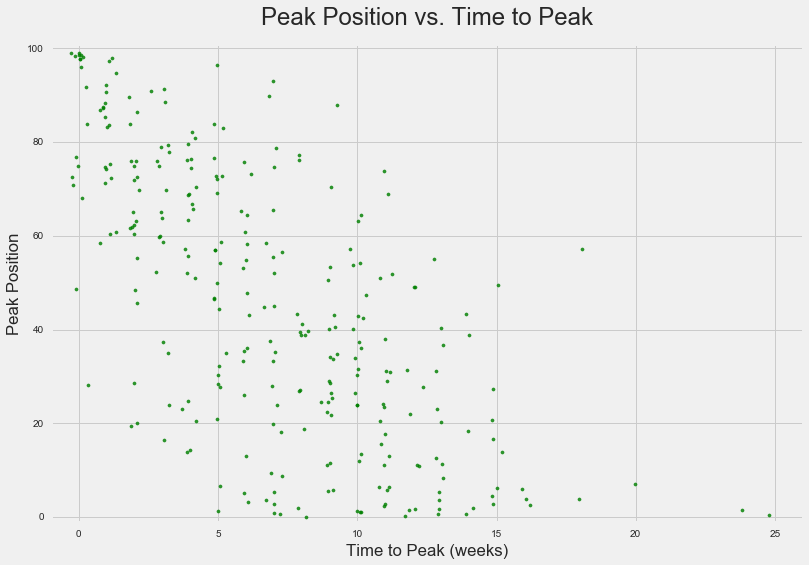

In [261]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

plt.scatter(rand_jitter(df['weeks_to_peak']), rand_jitter(df['peak_position']), \
            color = 'green', alpha = 0.8, s = 10)

plt.title('Peak Position vs. Time to Peak', fontsize = 24, y = 1.03)

# y label
plt.ylabel('Peak Position')

# x label
plt.xlabel('Time to Peak (weeks)')

# set the figure boundaries
plt.xlim([-1, 26])
plt.ylim([-1, 101])

plt.show()

In [262]:
df['genre'].value_counts()

Rock           132
Country         73
Rap             58
RnB             23
Reggae           0
Pop              0
Latin            0
Jazz             0
Gospel           0
Electronica      0
Name: genre, dtype: int64

In [264]:
colors = {'Rock' : 'red', 'Country' : 'orange', 'Rap' : 'green', 'RnB' : 'blue'}
df['colors'] = df['genre'].apply(lambda x: colors[x] if x in colors.keys() else 'grey')

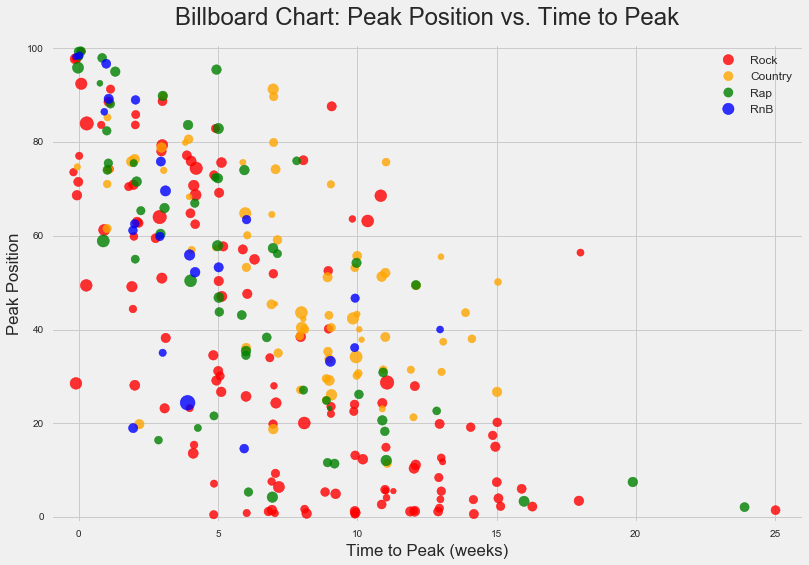

In [288]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

## Make area of dot proportional to song length
length_sizes = []
min_length = min(df['length'])
max_length = max(df['length'])
for i in df['length']:
    sizelet = ((max_length - min_length)/(400 - 20))*(i - min_length) + 20
    length_sizes.append(sizelet)
df['length_sizes'] = length_sizes
    
plt.scatter(rand_jitter(df[df['genre']=='Rock']['weeks_to_peak']), rand_jitter(df[df['genre'] \
            == 'Rock']['peak_position']), alpha=0.8, color = colors['Rock'], \
            s = df[df['genre'] == 'Rock']['length_sizes'], label = 'Rock')
plt.scatter(rand_jitter(df[df['genre']=='Country']['weeks_to_peak']), rand_jitter(df[df['genre'] \
            == 'Country']['peak_position']), alpha=0.8, color = colors['Country'], \
            s = df[df['genre'] == 'Country']['length_sizes'], label = 'Country')
plt.scatter(rand_jitter(df[df['genre']=='Rap']['weeks_to_peak']), rand_jitter(df[df['genre'] \
            == 'Rap']['peak_position']), alpha=0.8, color = colors['Rap'], \
            s = df[df['genre'] == 'Rap']['length_sizes'], label = 'Rap')
plt.scatter(rand_jitter(df[df['genre']=='RnB']['weeks_to_peak']), rand_jitter(df[df['genre'] \
            == 'RnB']['peak_position']), alpha=0.8, color = colors['RnB'], \
            s = df[df['genre'] == 'RnB']['length_sizes'], label = 'RnB')

plt.title('Billboard Chart: Peak Position vs. Time to Peak', fontsize = 24, y = 1.03)

# x label
plt.xlabel('Time to Peak (weeks)')

# y label
plt.ylabel('Peak Position')

# set the figure boundaries
plt.xlim([-1, 26])
plt.ylim([-1, 101])

plt.legend(loc='upper right', fontsize = 12)

plt.show()

I hypothesize that there is a linear relationship (alpha = 0.05) between the amount of time it takes a song to reach its top position on the Billboard chart and the rank of that peak position.  I will test against the null hypothesis that the slope of the regression line is equal to zero.

For regression line: 

        y = Β0 + Β1x

H0: Β1 = 0

Ha: Β1 ≠ 0

In [300]:
## Let's look at the least squares regression line with the function I wrote in class

def regress(x, y):
    x_bar = float(sum(x))/len(x)
    y_bar = float(sum(y))/len(y)
    xy_bar = sum([x[i]*y[i] for i in range(len(x))])/len(x)
    x_sq_bar = sum([float(x[i])**2 for i in range(len(x))])/len(x)
    beta_hat = (xy_bar - (x_bar * y_bar)) / (x_sq_bar - x_bar**2)
    alpha = y_bar - beta_hat * x_bar

    #print "x_bar: %s" %x_bar
    #print "y_bar: %s" %y_bar
    #print "xy_bar: %s" %xy_bar
    #print "x^2 bar: %s" %x_sq_bar
    print "B1 (slope): %s" %beta_hat
    print "B0 (intercept): %s" %alpha

    plt.figure(figsize=(12,8))
    plt.style.use('fivethirtyeight')

    df_scatter = plt.scatter(x, y, alpha=0.5, color = "darkblue", s = 20)

    plt.title('Time to Peak vs. Peak Position', fontsize = 24, y = 1.03)

    plt.ylabel('Peak Position')

    plt.xlabel('Time to Peak (weeks)')
    
    ablineValues = []
    for i in x:
        ablineValues.append(beta_hat*i+alpha)
    
    plt.xlim([-1, 26])
    plt.ylim([-1, 101])

    plt.plot(x, ablineValues, linewidth = .4, color = "darkgreen")
    plt.show()
    
    return

In [301]:
df = df.reset_index(drop=True)

B1 (slope): -4.17991963722
B0 (intercept): 74.1369278457


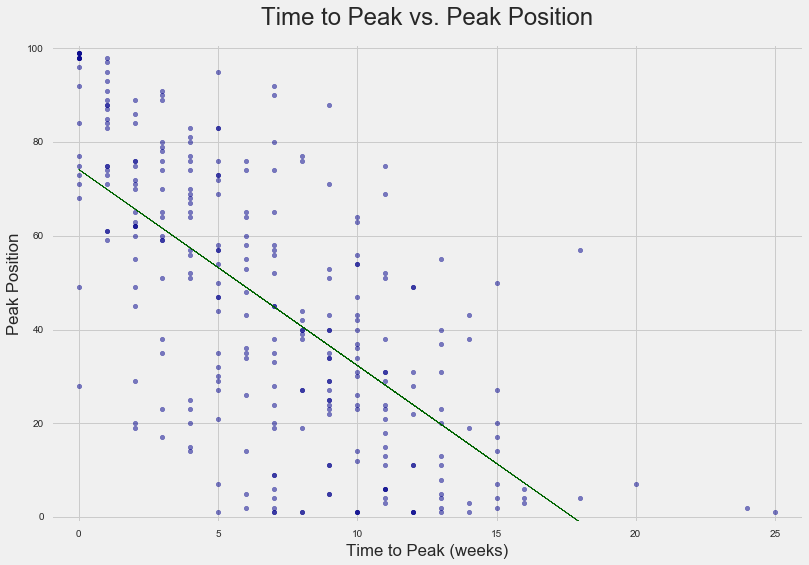

In [302]:
regress(df['weeks_to_peak'], df['peak_position'])

In [303]:
result = sm.OLS(df['peak_position'], df['weeks_to_peak']).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          peak_position   R-squared:                       0.251
Model:                            OLS   Adj. R-squared:                  0.248
Method:                 Least Squares   F-statistic:                     95.54
Date:                Wed, 31 Aug 2016   Prob (F-statistic):           1.20e-19
Time:                        02:22:13   Log-Likelihood:                -1503.9
No. Observations:                 286   AIC:                             3010.
Df Residuals:                     285   BIC:                             3013.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
weeks_to_peak     3.2428      0.332      9.775      0.000         2.590     3.896
==============================================================================
Omnibus:                       35.543   Durbin-Watson:                   0.111
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               10.016
Skew:                           0.012   Prob(JB):                      0.00668
Kurtosis:                       2.084   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [304]:
from scipy.stats import linregress

results2 = linregress(df['weeks_to_peak'], df['peak_position'])
results2

LinregressResult(slope=-4.1799196372194478, intercept=74.136927845703468, rvalue=-0.66697221983138077, pvalue=3.5889635551454457e-38, stderr=0.27708015961766852)

In [305]:
type(result.predict())

numpy.ndarray

Thus, at a 0.05 significance level with a p-value very near 0, we reject our null hypothesis that the peak position a song attains on the Billboard charts does not depend on the amount of time it takes to reach that position.  The shape of the plotted points makes sense intuitively (the longer a song is on the chart, the higher it will peak... something like listener momentum?  Or, if a song doesn't take very long to peak, it also isn't likely to leave very quickly afterward?).  **Add in observation from classmates regarding 20-wk cutoff; sample here is self-selected!**